# A Hands-on Project: Enhancing Customer Churn Prediction with Continuous Experiment Tracking in Machine Learning


![Author](https://img.shields.io/badge/Author-Nhi%20Yen-brightgreen)
[![Medium](https://img.shields.io/badge/Medium-Follow%20Me-blue)](https://medium.com/@nhiyen)
[![GitHub](https://img.shields.io/badge/GitHub-Follow%20Me-lightgrey)](https://github.com/nhiyen95)
[![Kaggle](https://img.shields.io/badge/Kaggle-Follow%20Me-orange)](https://www.kaggle.com/nhiyen95)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect%20with%20Me-informational)](https://www.linkedin.com/in/nhiyen95/)

-------------------
## Dataset: 
You can use the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/versions/1) dataset from Kaggle. This dataset contains information about telecom customers, including various features like contract type, monthly charges, and whether the customer churned or not.

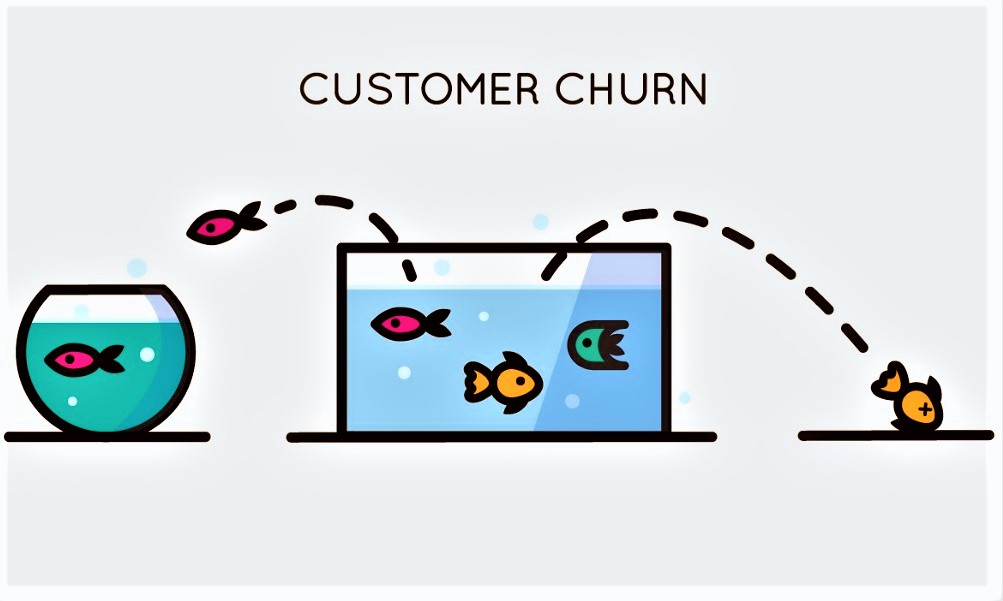!

## Objective: 
The goal of this project is to predict customer churn (whether a customer will leave the telecom service) using a model stacking approach. Model stacking involves training multiple models and combining their predictions using another model.

## Steps:

**1. Import Libraries**: Import necessary libraries and initialize Comet ML.

**2. Load and Explore Data**: Load dataset and perform exploratory data analysis (EDA).

**3. Preprocessing**: Preprocess data by encoding and scaling features.

**4. Model Training**: Train multiple machine learning models, including Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machine.

**5. Hyperparameter Tuning**: Use Optuna to optimize hyperparameters for the models.

**6. Ensemble Modeling**: Create a stacking ensemble of models for improved predictions.

**7. Optimization Results**: Display the best hyperparameters and accuracy.

**8. End Experiment**: Conclude the Comet ML experiment.

This project will give you insights into dealing with classification problems, handling imbalanced datasets (if applicable), and utilizing model stacking to enhance predictive performance.

# 0. Import Libraries

In [ ]:
!pip install -q optuna comet_ml
import optuna
import comet_ml
from comet_ml import Experiment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, log_loss

from kaggle_secrets import UserSecretsClient

# Set display options to show all columns
pd.set_option('display.max_columns', None)

# 1. Initialize Comet ML

In [ ]:
user_secrets = UserSecretsClient()
comet_api_key = user_secrets.get_secret("Comet API Key")

experiment = Experiment(
    api_key= comet_api_key,
    project_name="customer-churn",
    workspace="yennhi95zz"
)

# 2. Load Data

In [ ]:
# Load the dataset
data = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")  
data.head()

# 3. Perform EDA on the Dataset:

In [ ]:
data.info()

In [ ]:
# Convert 'TotalCharges' column to numerical
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Drop rows with missing values
data.dropna(inplace=True)

## 3.1. Customer Churn Distribution

This plot shows the distribution of churn vs. non-churn customers. You can see the number of customers who have churned (left the telecom service) and those who have not.


In [ ]:
# Plot 1: Class Distribution (Churn vs. Non-Churn)
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=data, x='Churn')
plt.title("Customer Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")

# Adding data labels (rounded) to the bars
for p in ax.patches:
    ax.annotate(f'{int(round(p.get_height()))}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Log the plot to Comet
experiment.log_figure(figure=plt)

plt.tight_layout()
plt.show()

## 3.2. Numeric Feature Distribution:

These histograms show the distribution of numeric features (tenure, MonthlyCharges, and TotalCharges) for the entire dataset.

In [ ]:
# Plot 2: Numeric Feature Distribution
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=data, x=feature, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Density')
# Log the plot to Comet
experiment.log_figure(figure=plt)

plt.tight_layout()
plt.show()

### 3.3. Categorical Feature Distribution:

These plots show the distribution of categorical features (gender, SeniorCitizen, Partner, Dependents, Contract, PaymentMethod) split by churn status.

These plots provide insights into how different categories of customers (e.g., seniors vs. non-seniors, customers with partners vs. without) are distributed in terms of churn. You can identify potential customer segments that are more likely to churn.



In [ ]:
# Plot 3: Categorical Feature Distribution
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=data, x=feature, hue='Churn', palette='Set2')
    plt.title(f'{feature} Distribution by Churn')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
# Log the plot to Comet
experiment.log_figure(figure=plt)

plt.tight_layout()
plt.show()

## 3.4. Correlation Heatmap:

The heatmap displays the correlation between numeric features in the dataset.

Understanding feature correlations can help in feature selection. For instance, if MonthlyCharges and TotalCharges are highly correlated, you might choose to keep only one of them to avoid multicollinearity in your models. It also helps identify which features might be more important in predicting churn.



In [ ]:
# Plot 4: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr(method='pearson', min_periods=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
# Log the plot to Comet
experiment.log_figure(figure=plt)

plt.tight_layout()
plt.show()

### 3.5. Monthly Charges vs. Total Charges:

This scatterplot shows the relationship between Monthly Charges and Total Charges, with points colored by churn status.

It appears that customers who have higher Total Charges are less likely to churn. This suggests that long-term customers who spend more are more loyal. You can use this insight to focus on retaining high-value, long-term customers by offering loyalty programs or incentives.
These business insights derived from EDA can guide feature engineering and model selection for your churn prediction project. They help you understand the data's characteristics and make informed decisions to optimize customer retention strategies.

In [ ]:
# Plot 5: Monthly Charges vs. Total Charges
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='MonthlyCharges', y='TotalCharges', hue='Churn', palette='Set2')
plt.title("Monthly Charges vs. Total Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Total Charges")
# Log the plot to Comet
experiment.log_figure(figure=plt)

plt.tight_layout()
plt.show()

# 4. Preprocessing

In [ ]:
# Encode categorical features, scale numerical features

encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(data.drop("Churn", axis=1), data["Churn"], test_size=0.2, random_state=42)

X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])

X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_val_scaled = scaler.transform(X_val[numerical_features])

X_train_processed = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_processed = np.concatenate((X_val_encoded, X_val_scaled), axis=1)


In [ ]:
# Split data into features and target
X = data.drop("Churn", axis=1)
y = data["Churn"]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Training and Hyperparameter Tuning:

**Logistic Regression (logreg):**

* Simple and interpretable model.
* Well-suited for binary classification tasks like churn prediction.
* Helps understand how features impact the chance of churn.

**Random Forest Classifier (rf):**

* Ensemble method combining multiple decision trees.
* Handles mixed feature types (categorical and numerical).
* Resistant to overfitting, good for complex datasets.

**Gradient Boosting Classifier (gb):**

* Sequential ensemble building strong predictive power.
* Captures complex relationships in data.
* Works well for various types of datasets.

**Support Vector Machine (svm):**

* Versatile model for linear and non-linear data.
* Can find complex decision boundaries.
* Useful when patterns between churn and non-churn are intricate.


**Modeling Stacking**

In the project, I am stacking models such as random forests, gradient boosting, and support vector machines, which have different characteristics and can capture different aspects of the customer churn problem. This ensemble approach can help you achieve a more accurate and robust churn prediction model, ultimately leading to better customer retention strategies and business outcomes.

## 5.1. Define an Optuna Objective Function:

In [ ]:
def objective(trial):
    # Define hyperparameter search space for individual models
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 300),
        'max_depth': trial.suggest_categorical('rf_max_depth', [None, 10, 20]),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 4),
    }

    gb_params = {
        'n_estimators': trial.suggest_int('gb_n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_categorical('gb_max_depth', [3, 4, 5]),
    }

    svm_params = {
        'C': trial.suggest_categorical('svm_C', [0.1, 1, 10]),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'rbf']),
    }

    # Create models with suggested hyperparameters
    rf = RandomForestClassifier(**rf_params)
    gb = GradientBoostingClassifier(**gb_params)
    svm = SVC(probability=True, **svm_params)

    # Train individual models
    rf.fit(X_train_processed, y_train)
    gb.fit(X_train_processed, y_train)
    svm.fit(X_train_processed, y_train)

    # Evaluate individual models on validation data
    rf_predictions = rf.predict(X_val_processed)
    gb_predictions = gb.predict(X_val_processed)
    svm_predictions = svm.predict(X_val_processed)

    # Calculate accuracy and ROC AUC for individual models
    rf_accuracy = accuracy_score(y_val, rf_predictions)
    gb_accuracy = accuracy_score(y_val, gb_predictions)
    svm_accuracy = accuracy_score(y_val, svm_predictions)

    rf_roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val_processed)[:, 1])
    gb_roc_auc = roc_auc_score(y_val, gb.predict_proba(X_val_processed)[:, 1])
    svm_roc_auc = roc_auc_score(y_val, svm.predict_proba(X_val_processed)[:, 1])

    # Create a stacking ensemble with trained models
    estimators = [
        ('random_forest', rf),
        ('gradient_boosting', gb),
        ('svm', svm)
    ]

    stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    # Train the stacking ensemble
    stacking_classifier.fit(X_train_processed, y_train)

    # Evaluate the stacking ensemble on validation data
    stacking_predictions = stacking_classifier.predict(X_val_processed)
    stacking_accuracy = accuracy_score(y_val, stacking_predictions)
    stacking_roc_auc = roc_auc_score(y_val, stacking_classifier.predict_proba(X_val_processed)[:, 1])

    # Log parameters and metrics to Comet ML
    experiment.log_parameters({
        'rf_n_estimators': rf_params['n_estimators'],
        'rf_max_depth': rf_params['max_depth'],
        'rf_min_samples_split': rf_params['min_samples_split'],
        'rf_min_samples_leaf': rf_params['min_samples_leaf'],
        'gb_n_estimators': gb_params['n_estimators'],
        'gb_learning_rate': gb_params['learning_rate'],
        'gb_max_depth': gb_params['max_depth'],
        'svm_C': svm_params['C'],
        'svm_kernel': svm_params['kernel']
    })

    experiment.log_metrics({
        'rf_accuracy': rf_accuracy,
        'gb_accuracy': gb_accuracy,
        'svm_accuracy': svm_accuracy,
        'rf_roc_auc': rf_roc_auc,
        'gb_roc_auc': gb_roc_auc,
        'svm_roc_auc': svm_roc_auc,
        'stacking_accuracy': stacking_accuracy,
        'stacking_roc_auc': stacking_roc_auc
    })

    # Return the negative accuracy as Optuna aims to minimize the objective
    return -stacking_accuracy


## 5.2. Optuna Hyperparameter Optimization:

Now, you can use Optuna to optimize the hyperparameters of your models. Optuna will search the hyperparameter space defined in the objective function and log the results to Comet ML.


Clarify the optimization goal: You should mention whether you are minimizing or maximizing a specific metric. In the code, I am using **direction='minimize', which implies optimizing accuracy (negative accuracy to minimize) AKA minimizing a loss or error metric**. If you want to maximize accuracy or ROC AUC, you should use direction='maximize'.

In [ ]:
from tabulate import tabulate

# Create and optimize the study
study = optuna.create_study(direction='minimize')  # Adjust direction based on your optimization goal
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Get the best hyperparameters and results
best_rf_params = study.best_params
best_accuracy = -study.best_value  # Convert back to positive accuracy

# Convert the dictionary to a list of key-value pairs for tabulation
param_table = [(key, value) for key, value in best_rf_params.items()]

# Display the best_rf_params table
best_rf_params = tabulate(param_table, headers=["Parameter", "Value"], tablefmt="grid")

print(f"Best RF Hyperparameters:\n{best_rf_params}")
print(f"Best Accuracy: {best_accuracy}")

In [ ]:
experiment.end()

# 6. Interpret the results

Detail explanation and interpret the results into business insights in the [blog](https://medium.com/@yennhi95zz/a-hands-on-project-enhancing-customer-churn-prediction-with-continuous-experiment-tracking-in-77aeaff242f7).


--------------
# References:
- [GitHub Repository](https://github.com/yennhi95zz/customer-churn-prediction-with-model-stacking)
- [Kaggle Project](https://www.kaggle.com/nhiyen/customer-churn-prediction-with-model-stacking)
- [Medium Article](https://medium.com/@yennhi95zz/a-hands-on-project-enhancing-customer-churn-prediction-with-continuous-experiment-tracking-in-77aeaff242f7)



--------------
👏If you found this article interesting, your support by commenting your insights in this post will help me spread the knowledge to others.

❗Found the articles helpful? Get **UNLIMITED** access to every story on Medium with just $1/week — [HERE](https://medium.com/@yennhi95zz/membership)

☕Buy Me a Coffee — [HERE](https://paypal.me/yennhi95zz)